### LAB 9
### Universidad del Valle de Guatemala
#### Data Science
##### Juan Marroquin 19845
##### Carlos Raxtum 19721

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np # linear algebra
import os # accessing directory structure
from pmdarima.arima import auto_arima
from pmdarima.model_selection import train_test_split
from prophet import Prophet
from helpers import *

C:\Users\melma\Documents\Juan Marro\Universidad\UVG\Octavo Semestre\Data Science\LABS\DataScience\LAB9\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
pd.set_option('display.max_columns', None)

###### carga de datos

In [3]:
df = pd.read_csv('aguacates_EEUU.csv',index_col=0)

In [4]:
# Explorar las primeras 5 filas del DataFrame
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [5]:
# Explorar las últimas 5 filas del DataFrame
df.tail()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
7,2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico
8,2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico
9,2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico
10,2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico
11,2018-01-07,1.62,17489.58,2894.77,2356.13,224.53,12014.15,11988.14,26.01,0.0,organic,2018,WestTexNewMexico


In [6]:
# Obtener información del conjunto de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18249 entries, 0 to 11
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          18249 non-null  object 
 1   AveragePrice  18249 non-null  float64
 2   Total Volume  18249 non-null  float64
 3   4046          18249 non-null  float64
 4   4225          18249 non-null  float64
 5   4770          18249 non-null  float64
 6   Total Bags    18249 non-null  float64
 7   Small Bags    18249 non-null  float64
 8   Large Bags    18249 non-null  float64
 9   XLarge Bags   18249 non-null  float64
 10  type          18249 non-null  object 
 11  year          18249 non-null  int64  
 12  region        18249 non-null  object 
dtypes: float64(9), int64(1), object(3)
memory usage: 1.9+ MB


In [7]:
## convert date column to date time format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

- Los datos representan ventas semanales desde 2015 a 2018 a nivel de todos los EEUU. 
- Los datos provienen directamente de las cajas registradoras basados en ventas de aguacate variedad Hass. 
- El precio promedio de los aguacates reflejan el costo por unidad, aún cuando estos se vendan por bolsas. 
- Los códigos (Product Lookup codes ó PLU) en la tabla son solo de aguacates Hass.  No se incluyen otras variedades.

Columnas relevantes en el conjunto de datos:

- Date - la fecha de la observación
- AveragePrice - el precio promedio de una unidad
- type - convencional u orgánico
- year - el año
- Region - la ciudad o región de la observación
- Total Volume - número total de aguacates vendidos
- 4046 - número total de aguacates con PLU 4046 vendidos
- 4225 - número total de aguacates con PLU 4225 vendidos
- 4770 - número total de aguacates con PLU 4770 vendidos

#### EDA

In [8]:
df.describe()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year
count,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000,18249.000000
mean,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04,3106.426507,2016.147899
std,0.402677,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,7.461785e+05,2.439660e+05,17692.894652,0.939938
min,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2015.000000
25%,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02,0.000000,2015.000000
50%,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03,0.000000,2016.000000
75%,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04,132.500000,2017.000000
max,3.250000,6.250565e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.937313e+07,1.338459e+07,5.719097e+06,551693.650000,2018.000000


In [9]:
df.describe(include=[object])

,type,region
count,18249,18249
unique,2,54
top,conventional,Albany
freq,9126,338


In [10]:
#df = df.dropna()
#df = df.reset_index(drop=True)

In [11]:
df.shape

(18249, 13)

#### order the df by date 

In [12]:
df = df.sort_values(by='Date',ascending=True)

#### Rename columns

In [13]:
df = df.rename(columns={'AveragePrice': 'y',
                        'Date': 'ds'})

### Averge Price vs Date

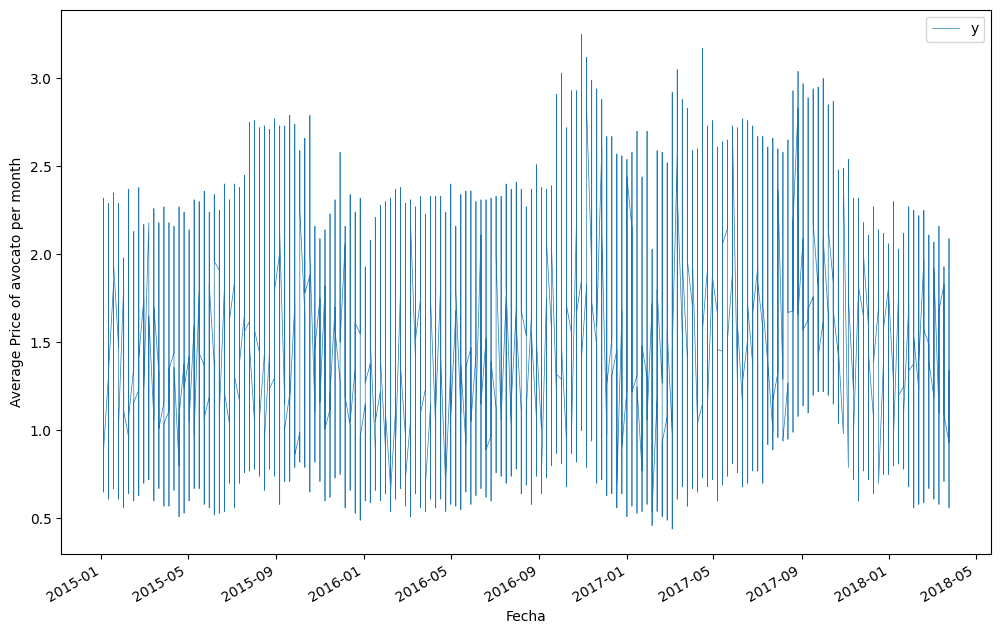

In [14]:
#variable para el size de las graficas
figsize = (12,8)
ax = df.plot(y='y',x='ds',figsize=figsize,linewidth=0.5)
ax.set_ylabel('Average Price of avocato per month')
ax.set_xlabel('Fecha')

plt.show();

Se puede observar que a nivel nacional, el precio del aguate durante las fechas no varia suficiente

#### Barplot of regions on the df

<AxesSubplot:title={'center':'Regions counts in the Df'}, xlabel='Regions counts in the df'>

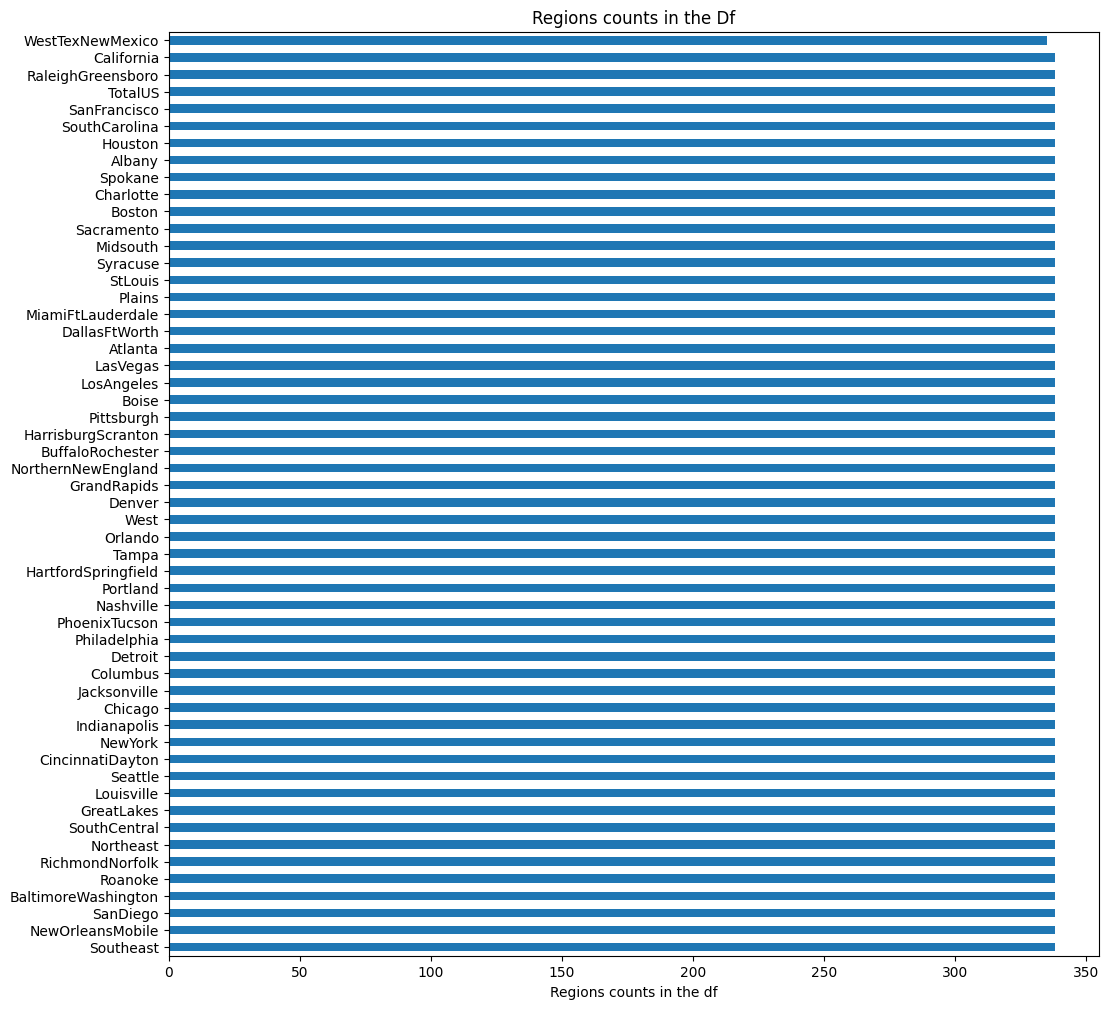

In [15]:
df['region'].value_counts().plot(kind='barh',figsize=(12,12),title="Regions counts in the Df",ylabel="", xlabel="Regions counts in the df")

#### Barplot of years on the df

<AxesSubplot:title={'center':'Year counts in the Df'}, xlabel='Years counts in the df'>

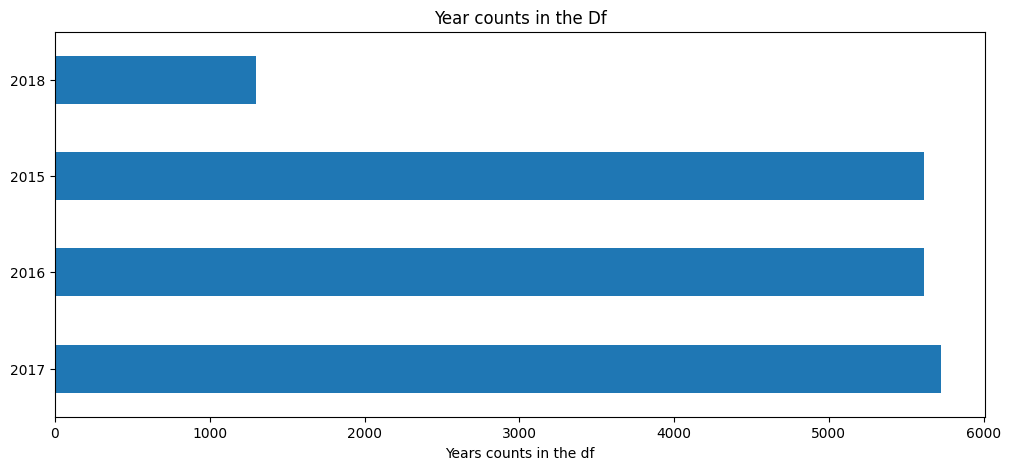

In [16]:
df['year'].value_counts().plot(kind='barh',figsize=(12,5),title="Year counts in the Df",ylabel="", xlabel="Years counts in the df")

Based on the chart aboard, we will not consider the year of 2018, because there is en data

In [17]:
#value_to_check = pd.Timestamp(2018, 1, 1)
#filter_mask = df['ds'] < value_to_check
#df = df[filter_mask]

In [18]:
totalUS = df[df['region'].isin(['TotalUS'])]

In [19]:
totalUS = totalUS[['ds','y']].reset_index(drop=True)

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [32]:
result = seasonal_decompose(totalUS[['y']], model='additive ', period=12)

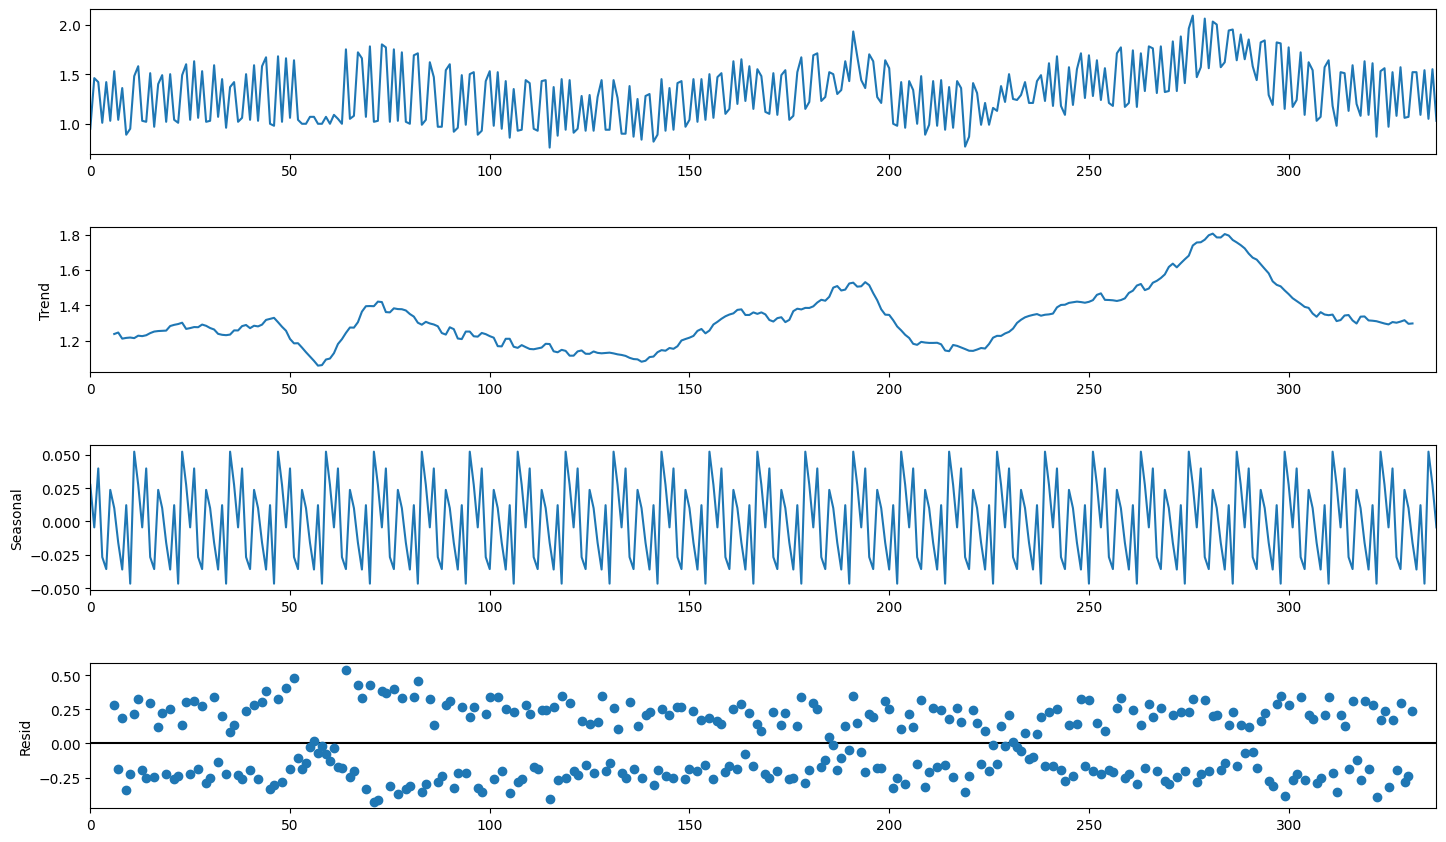

In [33]:
fig = result.plot()
fig.set_size_inches((16, 9))
plt.show()

In [22]:
Dickey_Fuller_test(totalUS.y)

ADF Statistic: -2.260468
p-value: 0.185035
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571


In [23]:
train, test,n_periods_val = split_train_test(totalUS)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=110.476, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=358.694, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=225.301, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=89.092, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=356.694, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=87.141, Time=0.10 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=89.096, Time=0.40 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=91.055, Time=0.86 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=58.789, Time=0.31 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=88.317, Time=0.84 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=62.160, Time=1.19 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=223.377, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=35.774, Time=0.25 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=37.546, Time=0.74 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC

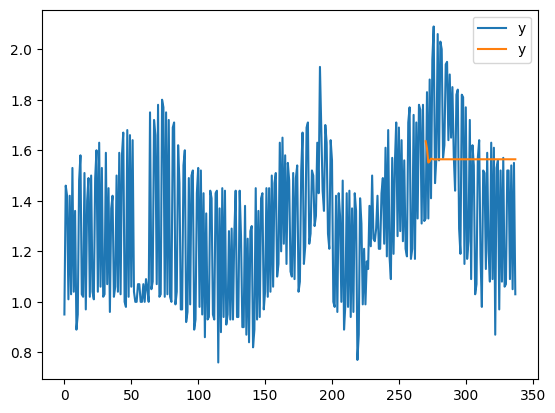

In [24]:
totalUS_model,totalUS_arima_prediction = arima_model(totalUS,train, test,n_periods_val)

21:47:48 - cmdstanpy - INFO - Chain [1] start processing
21:47:48 - cmdstanpy - INFO - Chain [1] done processing


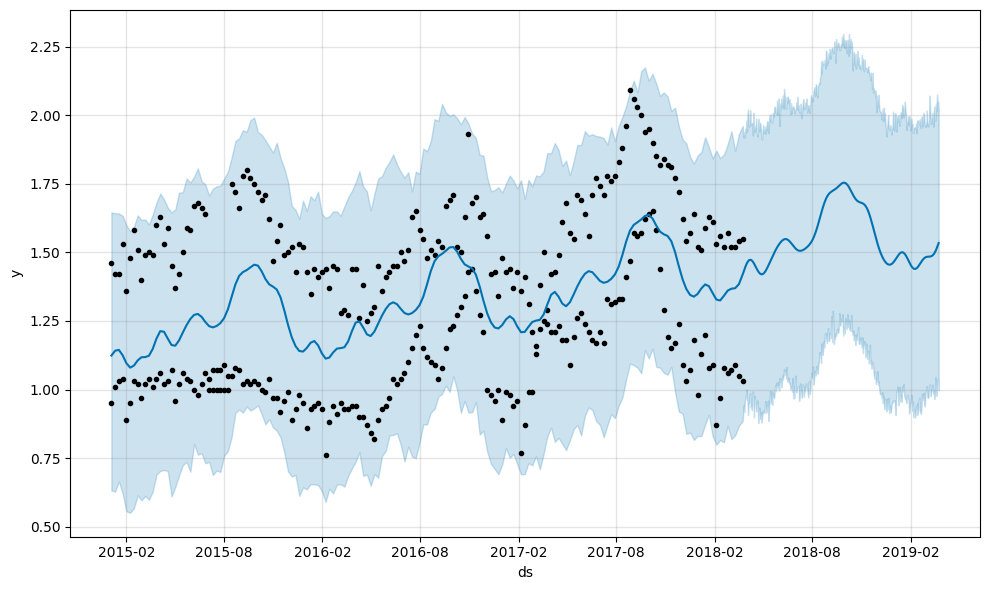

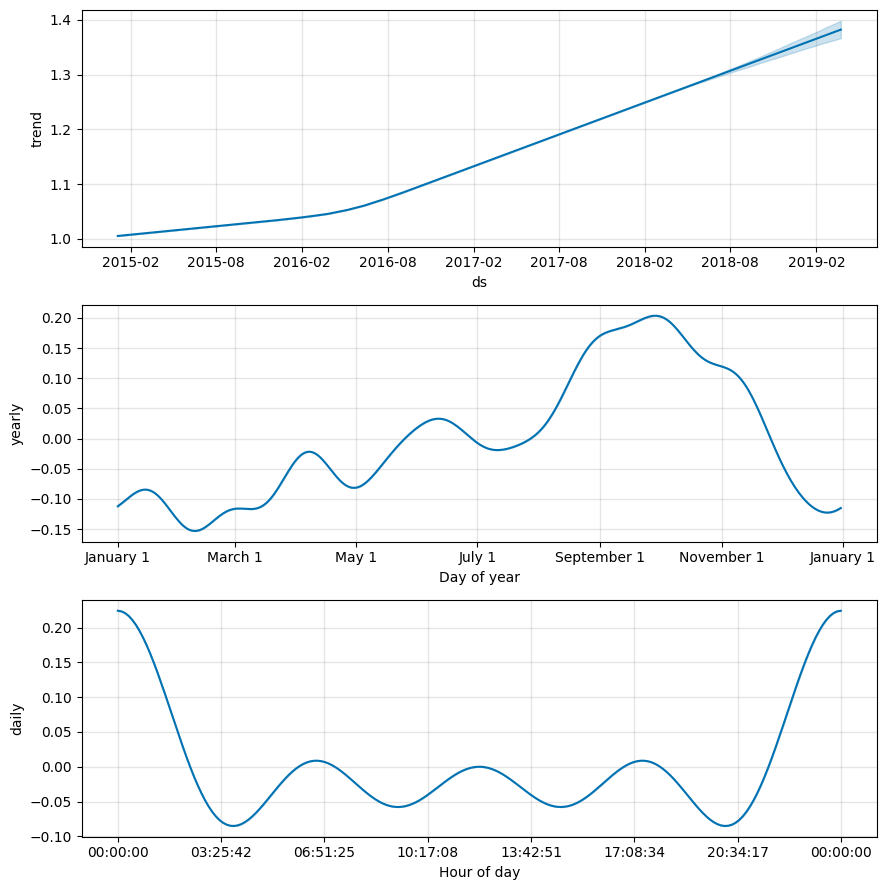

In [25]:
totalUS_model_P,prediction_totalUS,future_date_totalUS = Prophet_model(totalUS)

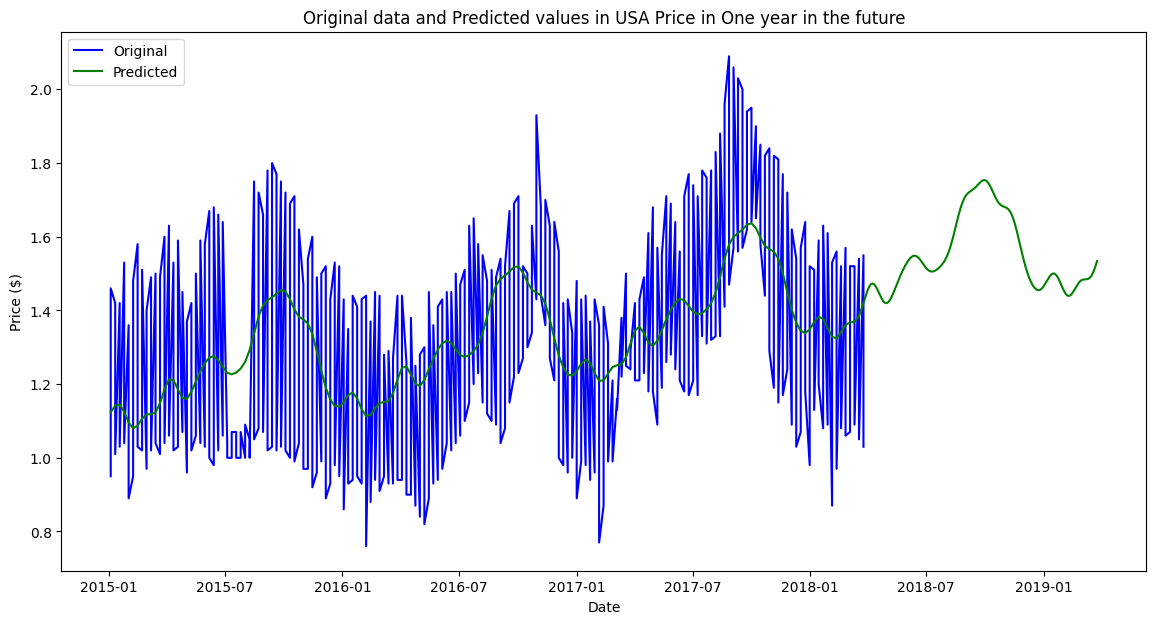

In [26]:
graph_prediction(totalUS,prediction_totalUS,'USA')

### Repetir el ejercicio pero solo con la región oeste "West" de los EEUU

In [27]:
west = df[df['region'].isin(['West'])]

In [28]:
west = west[['ds','y']].reset_index(drop=True)

In [30]:
result = seasonal_decompose(west[['y']], model='additive ', period=12)

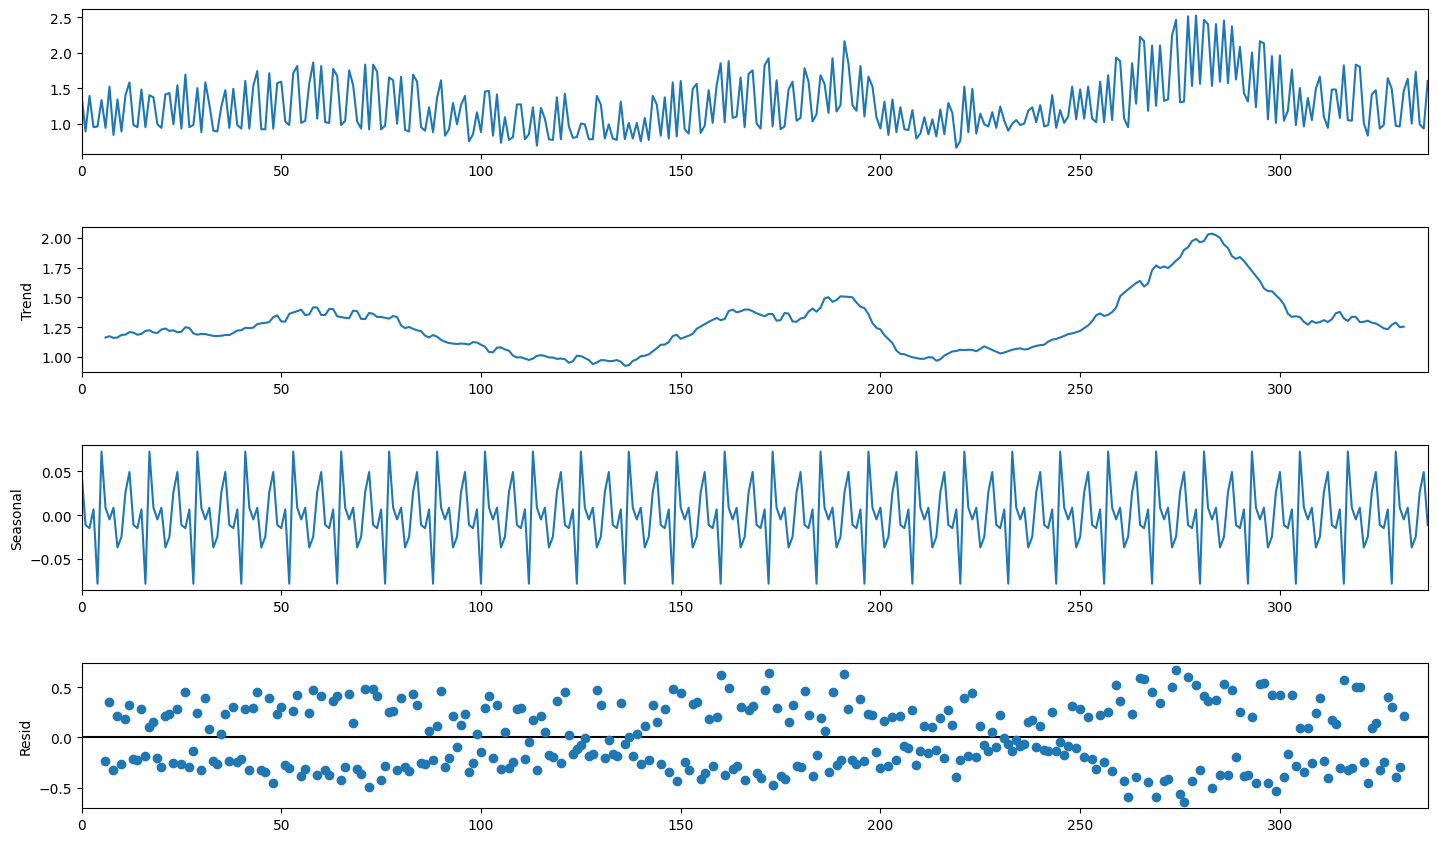

In [31]:
fig = result.plot()
fig.set_size_inches((16, 9))
plt.show()

In [34]:
Dickey_Fuller_test(west.y)

ADF Statistic: -2.537628
p-value: 0.106585
Critical Values:
	1%: -3.451
	5%: -2.870
	10%: -2.572


In [35]:
train, test,n_periods_val = split_train_test(west)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=235.601, Time=0.77 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=525.093, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=386.777, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=262.720, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=523.093, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=238.540, Time=0.21 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=237.207, Time=1.03 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=236.666, Time=1.78 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=235.255, Time=0.58 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=237.148, Time=1.45 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=238.876, Time=2.39 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=262.542, Time=0.37 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=216.854, Time=0.49 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=218.104, Time=0.18 sec
 ARIMA(2,1,1)(2,0,0)[12] intercep

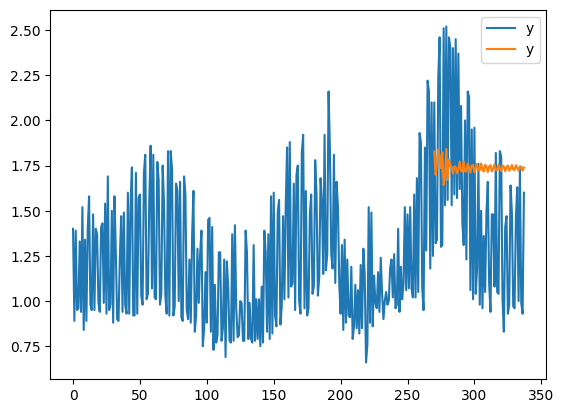

In [36]:
west_model,west_arima_prediction = arima_model(west,train, test,n_periods_val)

21:56:18 - cmdstanpy - INFO - Chain [1] start processing
21:56:18 - cmdstanpy - INFO - Chain [1] done processing


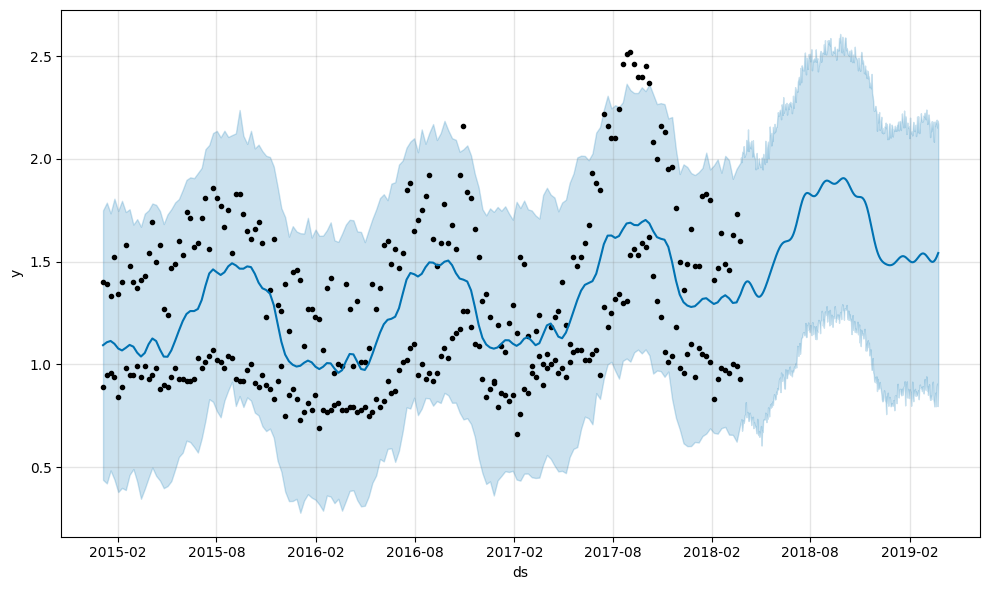

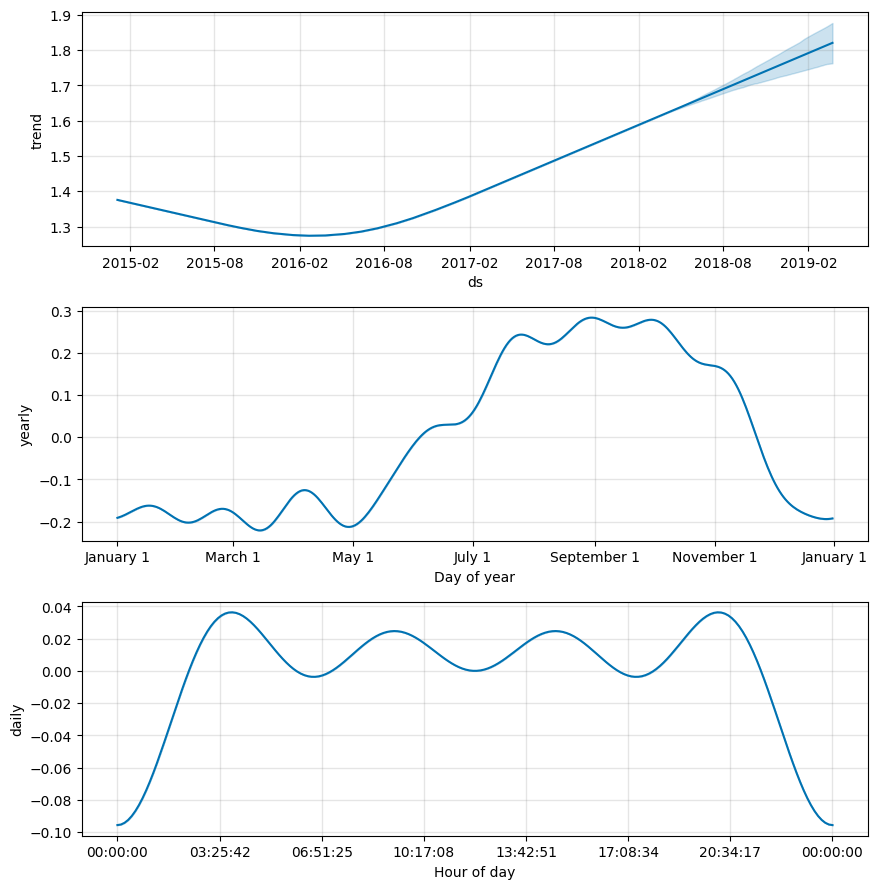

In [37]:
west_model_P,prediction_west,future_date_west = Prophet_model(west)

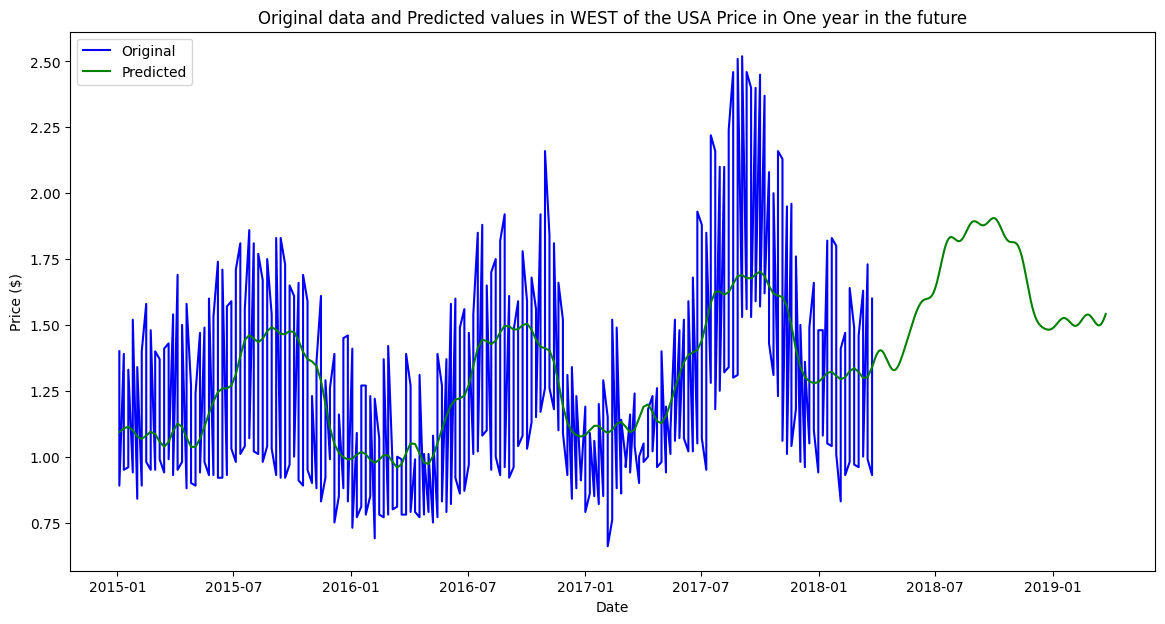

In [38]:
graph_prediction(west,prediction_west,'WEST of the USA')